[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/5_nb_supervised_learning.ipynb) 


# Chapter 5 - Algorithms for supervised learning 
The fifth chapter revisits two popular algorithms for supervised learning, the logistic regression model and classification and regression trees (CART). We examine their mathematical and statistical underpinnings to fully understand how logit and CART craft a model. Of course, we also exemplify how to use both algorithms in practice together with `sklearn`.  

The outline of the tutorial is as follows:
- Logistic regression
  - The logistic function
  - Maximum likelihood estimation
  - Logistic regression from scratch
  - Libraries for logistic regression
- Decision trees
  - Implementing a tree algorithm from scratch
  - Decision trees with `sklearn`

# Logistic regression
We learned from the lecture that the logistic regression model, or, in brief, logit model is the 'go-to' model for regression problems with a discrete target variable. Such problems are called classification problems. Formally speaking, logistic regression belongs to the wider family of **generalized linear models (GLM)**. It is a generalization of a linear regression model in that it embodies the well-known linear form $\beta^{\top} x$ and adds a (non-linear) **link function** that connects the linear form to the target variable. In the case of logistic regression, the link function is the logistic function. Other GLMs use different link functions, but these are out of scope. So let us first examine the logistic function.

## The logistic function
We implement the logistic function as a custom Python function and then generate some data to plot the function over the interval [-4, -3, ..., 4]. 
Recall that the form of the function for input variable $z$ is $f(z) = \frac{1}{1 + \exp^{-z}}$. 

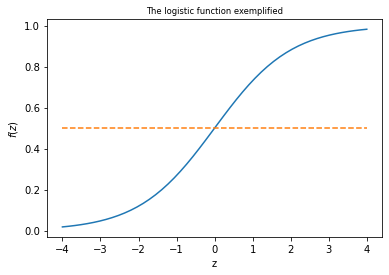

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# we implement the logistic function as a custom function
def logistic_fun(z):
    return 1/(1+np.exp(-z))


# create some data for plotting
z = np.linspace(-4, 4)

fz = logistic_fun(z)
plt.title("The logistic function exemplified", fontsize='small')
plt.plot(z, fz);
plt.plot(z, np.repeat(0.5, len(z)), "--");  #  just for fun, add a horizontal line to highlight 0.5
plt.ylabel("$f(z)$")
plt.xlabel("z")
plt.show()

It is a good exercise to check how changes in the above implementation change the plot. For example, you could add a constant multiplier and calculate $e^{(-\alpha z)} $ instead of $e^{(-z)}$, and check how the shape of the function changes with $\alpha$. 


## Maximum likelihood estimation & gradient descent
Estimating a logistic regression model involves minimizing the negative **log-likelihood** function. We discussed the maximum likelihood approach in the lecture. However, experience suggests that some students find this part a little hard  to digest, probably because of its level of formality. We will try to demystify the model by implementing it from scratch. For starters, however, recall that logistic regression models the probability of observing a certain state of our target variable $y$ by means of the logistic function. Assuming a zero-one coded binary target variable $y \in {0, 1}$, we can write the logit model as follows:

$$ p \left( y=1|x \right) = \frac{1}{1+e^{-z}}, \text{  and  }  p \left( y=0|x \right) = 1- p \left( y=1|x \right) $$

We define $z$ as a linear, additive function of the features $x$: 
$$ z = \hat{\beta}^{\top}x $$. 

Note that in the above equation, we assume for notational convenience that the feature vector $x$ includes a constant. This way, we do not need to explicitly consider the intercept. Assuming our data fulfills the IID assumption, we can write the log-likelihood function: 

$$ \mathcal{L} = \sum^{n}_{i=1} \left[ y_i \log \left(p \left( y=1|x \right) \right) + \left(1-y_i\right) \log \left(1-p \left( y=1|x \right) \right)\right]. $$

Now we need to find the values of $ \hat{\beta} $ that minimize this function. To that end, we calculate the derivative of the log likelihood function with respect to $ \hat{\beta} $. We calculate this derivative using the chain rule:

$$ \frac{\partial \mathcal{L}}{\partial \hat{\beta_j}} = \frac{\partial \mathcal{L}}{\partial p} \cdot \frac{\partial p}{\partial z} \cdot \frac{\partial z}{\partial \hat{\beta}} $$

Let's first calculate the three derivatives which we will need on the right hand side:

\begin{align*} 
\frac{\partial \mathcal{L}}{\partial p} &= \frac{y}{p} - \frac{1-y}{1-p} \\
\frac{\partial p}{\partial z} &= \frac{1}{1+e^{-z}} \cdot  \Bigg( 1 - \frac{1}{1+e^{-z}} \Bigg) = \Big( p \cdot  \big( 1 - p \big) \Big) \\
\frac{\partial z}{\partial \hat{\beta}} &= x
\end{align*}


Now we can multiply these three together to find the derivative of the log likelihood function with respect to $ \hat{\beta} $ :
 
\begin{align*}
 \frac{\partial \mathcal{L}}{\partial \hat{\beta}} &= \frac{\partial \mathcal{L}}{\partial p} \cdot \frac{\partial p}{\partial z} \cdot \frac{\partial z}{\partial \hat{\beta}} \\
 &= \Big( \frac{y}{p} - \frac{1-y}{1-p} \Big) \cdot \Big( p \cdot  \big( 1 - p \big) \Big) \cdot x \\
 &= (y(1-p) - p(1-y)) \cdot x \\ 
 &= (y - p) \cdot x
\end{align*}

And voilà! At the end, we have a much simpler formula to deal with:
$$ \frac{\partial \mathcal{L}}{\partial \hat{\beta}} = (y - p \left( y=1|x \right) ) \cdot x $$

The next step is to equate our derivate of zero and solve for the unknown parameter vector $\hat{\beta}$. However, different from linear regression, it turns out that there is no analytical solution. Therefore, we need to use another approach to find the optimal values of $\hat{\beta}$, that is the values that maximize the likelihood function.

**Gradient descent** is the process of iteratively making changes to $ \hat{\beta} $ to assess which values lower the derivative value and, therefore, hopefully brings us closer to a minimum. Note that this may unfortunately not be the global minimum of the function but rather a local minimum. This is especially true if we have many coefficients or if any relationships are very complicated.

Additionally, if we change $ \hat{\beta} $ by too much in one iteration, we may end up overshooting a minimum which is counterproductive. In order to avoid this, we multiply the total difference by the learning rate $ \eta $ to dampen the update to $ \hat{\beta} $. If the learning rate is too low however, we may end up sabotaging ourselves as the function loses too much momentum in its updates. It is a good idea to experiment with a few different rates to see which one works best with your data.

Here is an equation which represents gradient descent:
$$ \hat{\beta}_j = \hat{\beta}_{j-1} - \eta \frac{\partial \mathcal{L}}{\partial \hat{\beta}_{j-1}} $$

whereby we use the index $j$ to refer to individual iterations. For example, the above equation states how a new value of 
$\hat{\beta}_j$ depends on the value calculated in the previous iteration $\hat{\beta}_{j-1}$. Also note how our update rule embodies the value of our regression coefficients from the previous iteration with the gradient of our loss function $\mathcal{L}$ with respect to $\hat{\beta}_{j-1}$. Essentially, the above equation says that, to update our regression parameters $\hat{\beta}$, take their values from the previous iteration and change these in the direction of the negative of the gradient, which is the direction in that our loss function decreases the most. The degree to which the new values of $\hat{\beta}$ depend on the previous values and the gradient, in other words the magnitude of the update, depend on the parameter $\eta$, which is called the learning rate. 

For a more detailed explanation, check out the [Wikipedia page for *gradient descent*](https://en.wikipedia.org/wiki/Gradient_descent). It will be crucial for you to understand this process, so take advantage of online resources to improve your understanding. There are also many ways to modify this process like stochastic gradient descent or adaptive learning rates which you might come across in future studies.

## Libraries for logistic regression

Now that we know that estimating a logistic regression model using the maximum likelihood approach is not some sort of dark magic, we might feel more comfortable with using libraries that hide all the details. In fact, you have already seen one such library in action in [Tutorial 3](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/3_nb_predictive_analytics.ipynb). There, we used the `statsmodels` library to estimate a logit model. Let's revisit the corresponding codes. However, doing so for our toy data is pointless. It's time for a real-world data set and since we spent so much time on cleaning and preparing and understanding the HMEQ data in [Tutorial 4](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/4_nb_data_preparation.ipynb), it would be a shame to not use it for demonstrating logistic regression on some real data. Remember that [Tutorial 4](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/4_nb_data_preparation.ipynb) discusses that data set in detail, so simply go back to the previous tutorial is you need a refresher.

In [4]:
import pandas as pd 
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
# Load data from GitHub
df = pd.read_csv('../data/hmeq_modeling.csv', index_col="index")

Let's take a quick look at the data to re-familiarize ourselves with the classification task.

In [5]:
df.head(5)

,BAD,LOAN,MORTDUE,VALUE,YOJ,CLAGE,NINQ,CLNO,DEBTINC,DEROGzero,REASON_HomeImp,REASON_IsMissing,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,DELINQcat_1,DELINQcat_1+
index,,,,,,,,,,,,,,,,,,,
0,True,-1.832283,-1.295882,-1.335526,0.266788,-1.075278,-0.065054,-1.297476,0.137456,True,1,0,0,1,0,0,0,0,0
1,True,-1.810666,-0.013474,-0.672699,-0.236615,-0.723092,-0.826792,-0.756608,0.137456,True,1,0,0,1,0,0,0,0,1
2,True,-1.789048,-1.654549,-1.839275,-0.668103,-0.368769,-0.065054,-1.189302,0.137456,True,1,0,0,1,0,0,0,0,0
3,True,-1.789048,-0.159552,-0.202559,-0.236615,-0.061033,-0.065054,-0.107566,0.137456,True,0,1,0,1,0,0,0,0,0
4,False,-1.767431,0.791699,0.311107,-0.811933,-1.088528,-0.826792,-0.756608,0.137456,True,1,0,1,0,0,0,0,0,0


In [6]:
# Split into target and features
y = df.BAD.values.astype(int)
X = df.iloc[:,1:]

# We add a constant column to X. Think of this as the Python way to include an intercept in your model 
X = add_constant(X, prepend=True, has_constant='raise')
# Estimate logit model
logit_model = sm.Logit(y, X.astype(float), ) 
logit_model = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.394606
         Iterations 7


A nice feature of the `statsmodels` implementation is that you can easily produce a standard regression table. 

In [7]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 5960
Model:                          Logit   Df Residuals:                     5941
Method:                           MLE   Df Model:                           18
Date:                Sun, 04 Sep 2022   Pseudo R-squ.:                  0.2103
Time:                        13:47:48   Log-Likelihood:                -2351.8
converged:                       True   LL-Null:                       -2978.2
Covariance Type:            nonrobust   LLR p-value:                5.480e-255
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.1279      0.134     -8.389      0.000      -1.391      -0.864
LOAN                -0.1706      0.042     -4.018      0.000      -0.254      -0.087
MORTDUE             -0.1583      0.067     -2.366      0.018      -0.289      -0.027
VALUE                0.0619      0.070      0.885      0.376      -0.075       0.199
YOJ                 -0.0619      0.041     -1.510      0.131      -0.142       0.018
CLAGE               -0.4503      0.043    -10.520      0.000      -0.534      -0.366
NINQ                 0.2806      0.035      7.944      0.000       0.211       0.350
CLNO                -0.1448      0.042     -3.434      0.001      -0.227      -0.062
DEBTINC              0.4379      0.044     10.033      0.000       0.352       0.523
DEROGzero           -1.1282      0.097    -11.653      0.000      -1.318      -0.938
REASON_HomeImp       0.2465      0.086      2.878      0.004       0.079       0.414
REASON_IsMissing     0.3610      0.199      1.812      0.070      -0.030       0.751
JOB_Office          -0.6247      0.148     -4.219      0.000      -0.915      -0.335
JOB_Other           -0.0035      0.115     -0.031      0.976      -0.229       0.222
JOB_ProfExe          0.0853      0.133      0.643      0.520      -0.174       0.345
JOB_Sales            1.0241      0.261      3.925      0.000       0.513       1.536
JOB_Self             0.6369      0.212      3.005      0.003       0.221       1.052
DELINQcat_1          1.1760      0.104     11.334      0.000       0.973       1.379
DELINQcat_1+         2.1360      0.112     19.108      0.000       1.917       2.355
====================================================================================
"""

Spend a little time on inspecting the table. The pseudo $R^2$ statistic suggests that the model explains only a moderate amount of the variability of the target variable. However, we find from the *LLR test* that the model as a whole is highly significant. Further, most features come out as significant,  two dummy variables for the job categories *prof. executive* and *other* and the feature VALUE being an exception. Remember the result of the analysis of feature correlation in [Tutorial 4](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/4_nb_data_preparation.ipynb)? The result for the VALUE feature is surely due to the high correlation of this feature with MORTDUE.    

In [8]:
np.corrcoef(df.MORTDUE, df.VALUE)

array([[1.        , 0.82513958],
       [0.82513958, 1.        ]])

Reestimating the logit model after removing the feature MORTDUE would be a good exercise. After the modification, VALUE should come out as significant.

We could easily continue our discussion of the regression table to draw more conclusions about our data. However, this is not the point the focal tutorial. Instead, let's look at another implementation of logistic regression. The famous `scikit-learn` library is the goto library for machine learning in Python. We will use it intensively throughout the course. It also supplies an implementation of logistic regression. Let's see how to use that implementation      

In [9]:
from sklearn.linear_model import LogisticRegression

sk_logit = LogisticRegression(penalty='none', fit_intercept=False)  # Recall that we already included a constant column in X. 
sk_logit.fit(X, y)                                                  # So we must set fit_intercept to False

LogisticRegression(fit_intercept=False, penalty='none')

The sklearn implementation is geared toward predictive modeling. For example, there is no way to easily obtain fitting statistics or shed light on the significance of features. On the other hand, the class `LogisticRegression` supports many advanced features to maximize the predictive power of the logit model. The above output already hints at the many different parameters that you can configure. Have a look into the help if you'd like to learn more. We will cover important parameters like those associated with *regularization* in[ Tutorial 7](https://github.com/Humboldt-WI/bads/blob/master/tutorials/7_nb_model_selection.ipynb).

One easy to appreciate advantage of `sklearn` over `statsmodels` when it comes to logistic regression is scalability. The sklearn implementation is faster and can cope with larger data sets. Given the differences between our two logit models, the only way to compare them (for now) is by inspecting the estimated model coefficients.  

In [10]:
# Create a dataframe for the comparison
# Note that we also need some conversions to ensure that the two coefficient arrays are compatible
df_comparison = pd.DataFrame({"statsmodels" :logit_model.params.to_numpy(), "sklearn": sk_logit.coef_[0]})
df_comparison

,statsmodels,sklearn
0,-1.127897,-1.127687
1,-0.170567,-0.170544
2,-0.158264,-0.158239
3,0.061895,0.061884
4,-0.061869,-0.061875
5,-0.450325,-0.450316
6,0.280649,0.280644
7,-0.144770,-0.144765
8,0.437894,0.437879
9,-1.128196,-1.128196


**Conclusion:** the two implementations of the logit model deliver similar results. That is nice but maybe not too exciting. The main take-away is that, when it comes to logistic regression, ask yourself whether you want to use the model for an explanatory or predictive purpose. Use the implementation within `statsmodels` in the former and `sklearn` in the latter case.

# Decision Trees

Decision trees are useful and powerful algorithms for classifying and regressing data. They work by on recursive partitioning which will be shown algorithmically in this notebook. Though most of the the time, sklearn can be used to implement this machine learning method, it is useful to take a look at the inner workings of tree-based algorithms. The following parts will first introduce a decision tree from scratch, before demonstrating its coverage in sklearn. 

## Decision Tree From Scratch Using HMEQ Data

Firstly, we will go through a decision tree made from scratch. The following code is based on the material originally created by Sebastian Mantey for the Iris Dataset whose GitHub is here: https://github.com/SebastianMantey/Decision-Tree-from-Scratch. You can also search his video on YouTube. The code has been adapted to this course's format and fit to HMEQ Dataset.

Just in case you made changes to the data by running the above code, we first reload the data to a fixed and clear-defined starting point for our tree classifier. Recall that we defined the variable `data_url` above.

In [11]:
df = pd.read_csv('../data/hmeq_modeling.csv', header = 0, index_col = 0) # import file with header and index as first row and column respectively

df.head() #inspect data to make sure it looks correct

,BAD,LOAN,MORTDUE,VALUE,YOJ,CLAGE,NINQ,CLNO,DEBTINC,DEROGzero,REASON_HomeImp,REASON_IsMissing,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,DELINQcat_1,DELINQcat_1+
index,,,,,,,,,,,,,,,,,,,
0,True,-1.832283,-1.295882,-1.335526,0.266788,-1.075278,-0.065054,-1.297476,0.137456,True,1,0,0,1,0,0,0,0,0
1,True,-1.810666,-0.013474,-0.672699,-0.236615,-0.723092,-0.826792,-0.756608,0.137456,True,1,0,0,1,0,0,0,0,1
2,True,-1.789048,-1.654549,-1.839275,-0.668103,-0.368769,-0.065054,-1.189302,0.137456,True,1,0,0,1,0,0,0,0,0
3,True,-1.789048,-0.159552,-0.202559,-0.236615,-0.061033,-0.065054,-0.107566,0.137456,True,0,1,0,1,0,0,0,0,0
4,False,-1.767431,0.791699,0.311107,-0.811933,-1.088528,-0.826792,-0.756608,0.137456,True,1,0,1,0,0,0,0,0,0


In [12]:
X = df.drop(['BAD'], axis=1) #code the variables in the most standard way for your usage
y = df[['BAD']]

In [13]:
print(type(X), type(y), X.shape, y.shape) # double check that types and dimensions are correct before proceeding

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> (5960, 18) (5960, 1)


## Decision Trees with sklearn

As mentioned, the sklean library supports tree-based algorithms, which are a lot easier to use compared to coding a tree algorithm from scratch. Armed with the knowledge of the inner workings of a decision tree, it should be easier to understand what this algorithm is trying to achieve.

In [14]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(criterion="entropy", min_samples_split=2, max_depth=2) #keep tree at a low depth

dt_shallow = clf.fit(X, y)

In [15]:
pred_dt_shallow = dt_shallow.predict(X)

In [16]:
pred_dt_shallow[0:5]

array([ True,  True,  True,  True,  True])

In [17]:
classify_correct_shallow = pred_dt_shallow == y.iloc[:,0]
accuracy_shallow = classify_correct_shallow.mean()


accuracy_shallow

0.851006711409396

[Text(167.4, 181.2, 'X[7] <= 0.133\nentropy = 0.721\nsamples = 5960\nvalue = [4771, 1189]'),
 Text(83.7, 108.72, 'X[17] <= 0.5\nentropy = 0.315\nsamples = 2341\nvalue = [2208, 133]'),
 Text(41.85, 36.23999999999998, 'entropy = 0.261\nsamples = 2215\nvalue = [2117, 98]'),
 Text(125.55000000000001, 36.23999999999998, 'entropy = 0.852\nsamples = 126\nvalue = [91, 35]'),
 Text(251.10000000000002, 108.72, 'X[7] <= 0.137\nentropy = 0.871\nsamples = 3619\nvalue = [2563, 1056]'),
 Text(209.25, 36.23999999999998, 'entropy = 0.959\nsamples = 1273\nvalue = [486, 787]'),
 Text(292.95, 36.23999999999998, 'entropy = 0.514\nsamples = 2346\nvalue = [2077, 269]')]

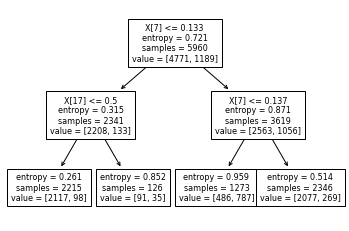

In [18]:
tree.plot_tree(dt_shallow, fontsize=8)

### SKLearn Tree with No Limit on Depth

If we remove the maximum depth parameter, the algorithm will go as far as it can until all nodes are pure.

In [19]:
clf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=2)

dt_deep = clf.fit(X, y)

pred_dt_deep = dt_deep.predict(X)

In [20]:
pred_dt_deep[0:5]

array([ True,  True,  True,  True, False])

In [21]:
classify_correct_deep = pred_dt_deep == y.iloc[:,0]
accuracy_deep = classify_correct_deep.mean()

accuracy_deep

1.0

While this seems great at first glance, what is the problem here? What does this mean for new data that we encounter whose idiosyncracies may be slightly different than the data we used to train the model?